In [6]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from math import log
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
# show more dataframe rows
pd.set_option('display.min_rows', 50)
pd.set_option('display.max_rows', 100)

def g(w, k):
    return 1/(w+k) * ((w+k+(w-1))//w)

def read(file):
    with open(f'../data/{file}', 'r') as f:
        data = json.load(f)
    return pd.json_normalize(data)

def normalize(df):
    # Rename column 'tp.minimizer_type' to 'Minimizer type'
    df = df.rename(columns={'tp.minimizer_type': 'Minimizer type'})
    # In type column replace minizer value with random minimizer.
    df['Minimizer type'] = df['Minimizer type'].replace('Minimizer', 'Random minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('LrMinimizer', 'LR-minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('ModMinimizer', 'Mod-minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('MiniceptionNew', 'Modified miniception')


    df = df[df.k >= np.log(df.w)/np.log(df.sigma)]
    if 'tp.k0' in df.columns:
        df['param'] = df['tp.k0'].fillna(0) #+ df['tp.r'].fillna(0)

    # df.sort_values(by='Minimizer type', inplace=True)

    return df


In [7]:
def plot(data):
    if isinstance(data, str):
        data = read(data)
    df = normalize(data)
    s = df['sigma'].unique()[0]
    ws = df.w.unique()

    for w in ws:
        plt.axhline(y=(1)/(w), color='black', linewidth=0.5)
        plt.axhline(y=(2)/(w+1), color='black', linewidth=0.5)
        ks = range(df.k.min(), df.k.max())
        plt.plot(ks, [g(w,k) for k in ks], color='red', linewidth=0.5)

    sns.lineplot(x='k', y='density', hue='Minimizer type', size='w', sizes=(1,2), data=df, legend='full', marker='.', dashes=False);
    plt.title(f'Minimizer density on random text (alphabet size σ={s}; length=5M)')
    plt.xlabel('Kmer length k')
    plt.ylabel('Density')
    plt.yscale('log', base=2)
    plt.yticks([2/(w+1) for w in ws]+[1/w for w in ws],[f'{2/(w+1):.3f}' for w in ws]+[f'{1/w:.3f}' for w in df.w.unique()])
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.savefig(f'../fig/density_{s}.svg', bbox_inches='tight')
    plt.show()

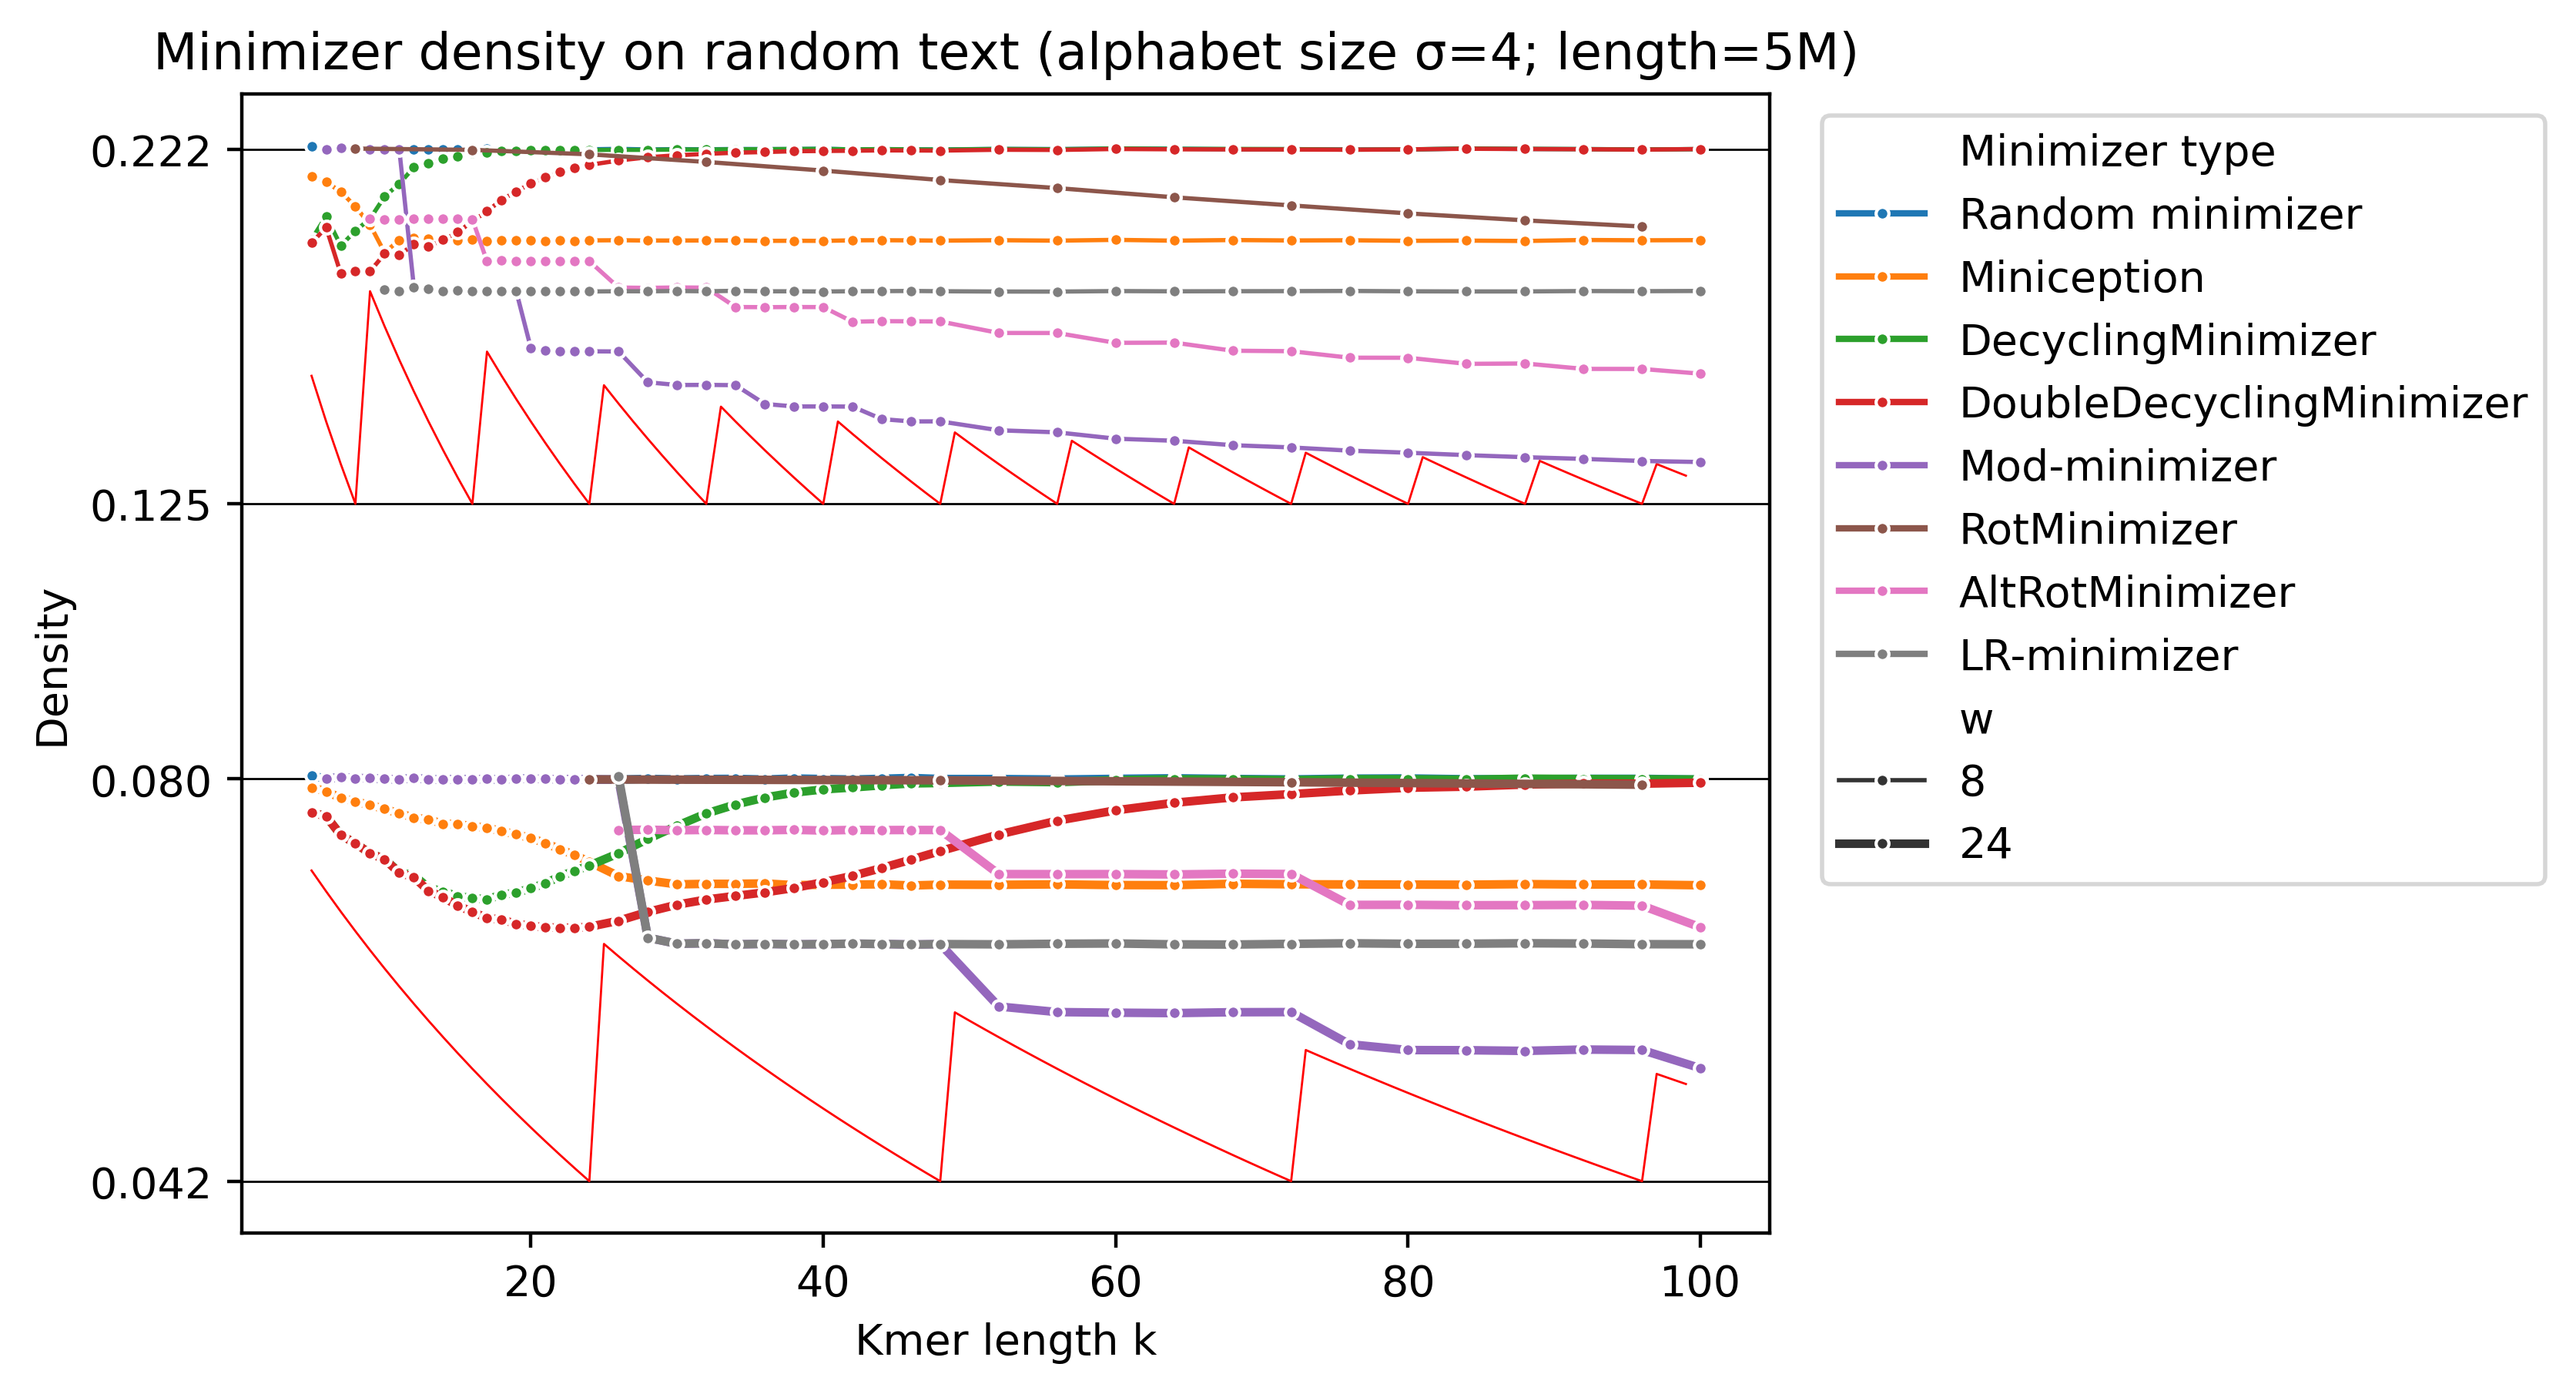

In [8]:
plot('density_4.json')

In [9]:
%load_ext autoreload
%autoreload 2

In [1]:
import minimizers.minimizers
n = 1000000
sigma = 4
text = minimizers.generate_random_string(n, sigma)

In [2]:
w = 24
ks = range(1, 60)
tps = [
    ('OpenClosedSyncmerMinimizer', True, 4),
    ('OpenClosedSyncmerMinimizer', False, 4),
    ('OpenSyncmerMinimizer', True, 4),
    ('OpenSyncmerMinimizer', False, 4),
]

plt.plot(ks, [g(w,k) for k in ks], color='red', linewidth=0.5)
for (tp, tiebreak, t) in tps:
    ds = []
    for k in ks:
        print(f'{k}\r', end='', flush=True)
        d=minimizers.density(tp, text, w, k, sigma, tiebreak=tiebreak, t=t)
        ds.append(d)
    plt.plot(ks, ds, label=f'{tp} {tiebreak} {t}')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

NameError: name 'plt' is not defined

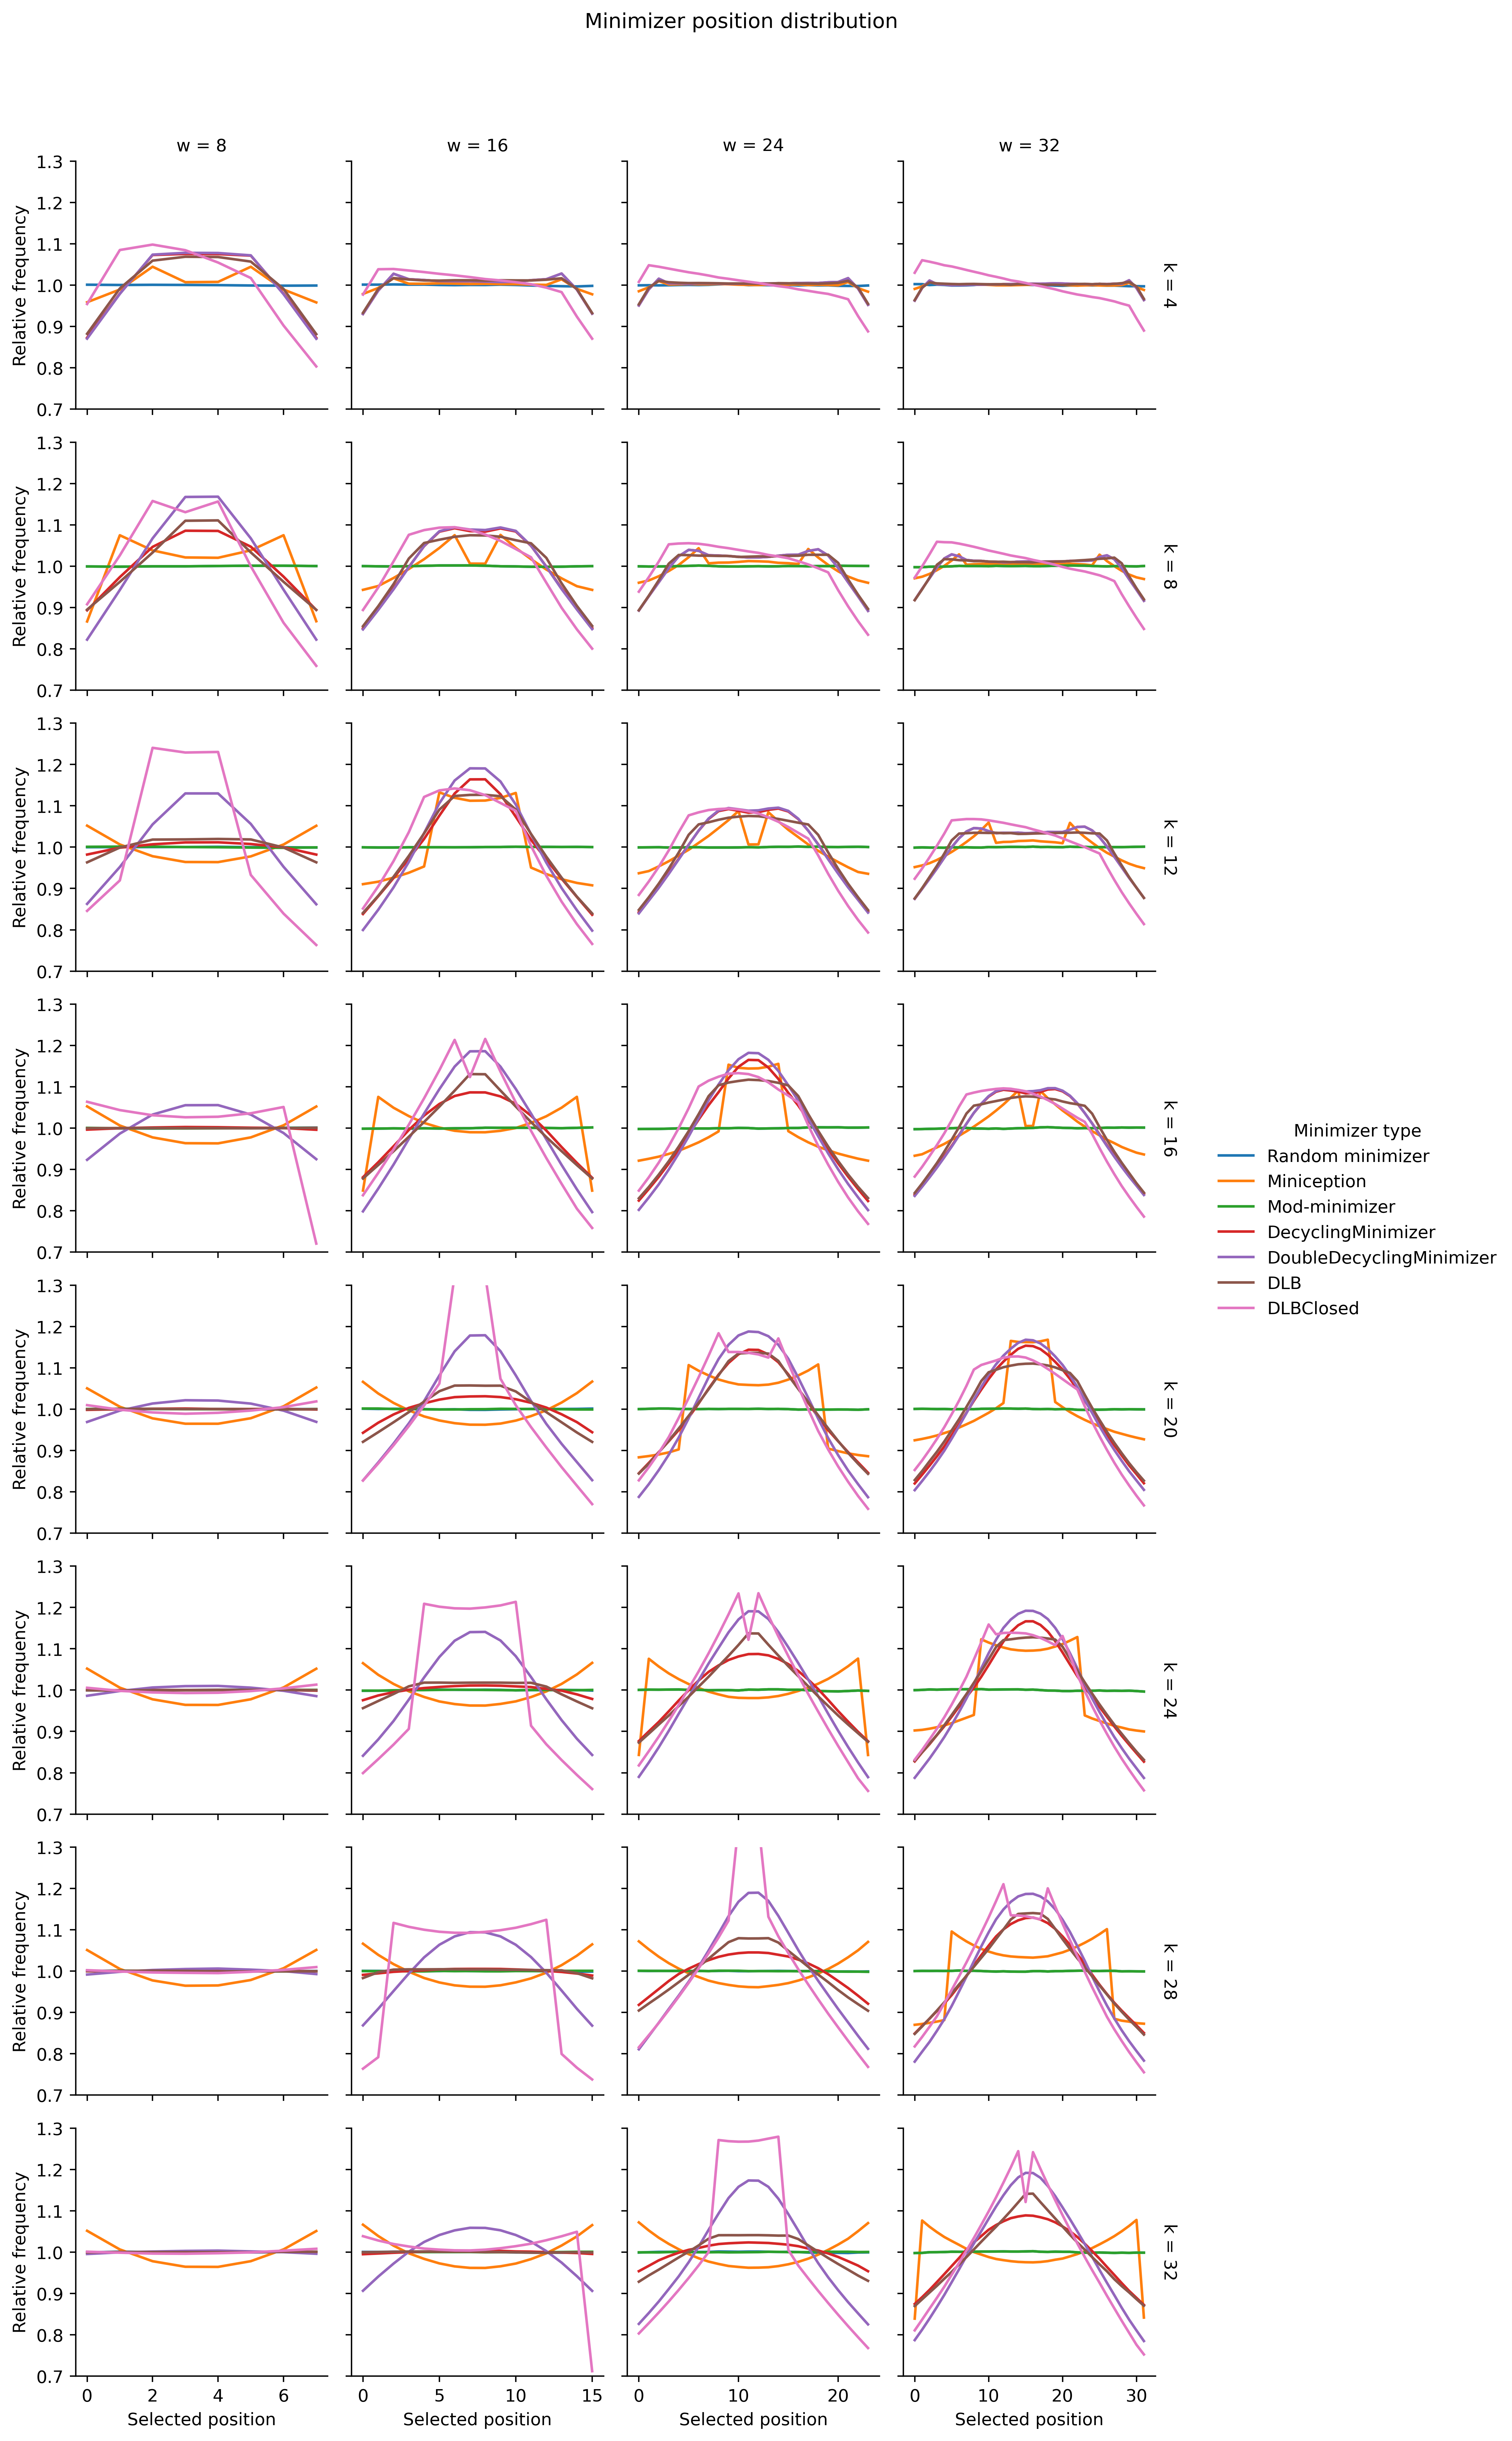

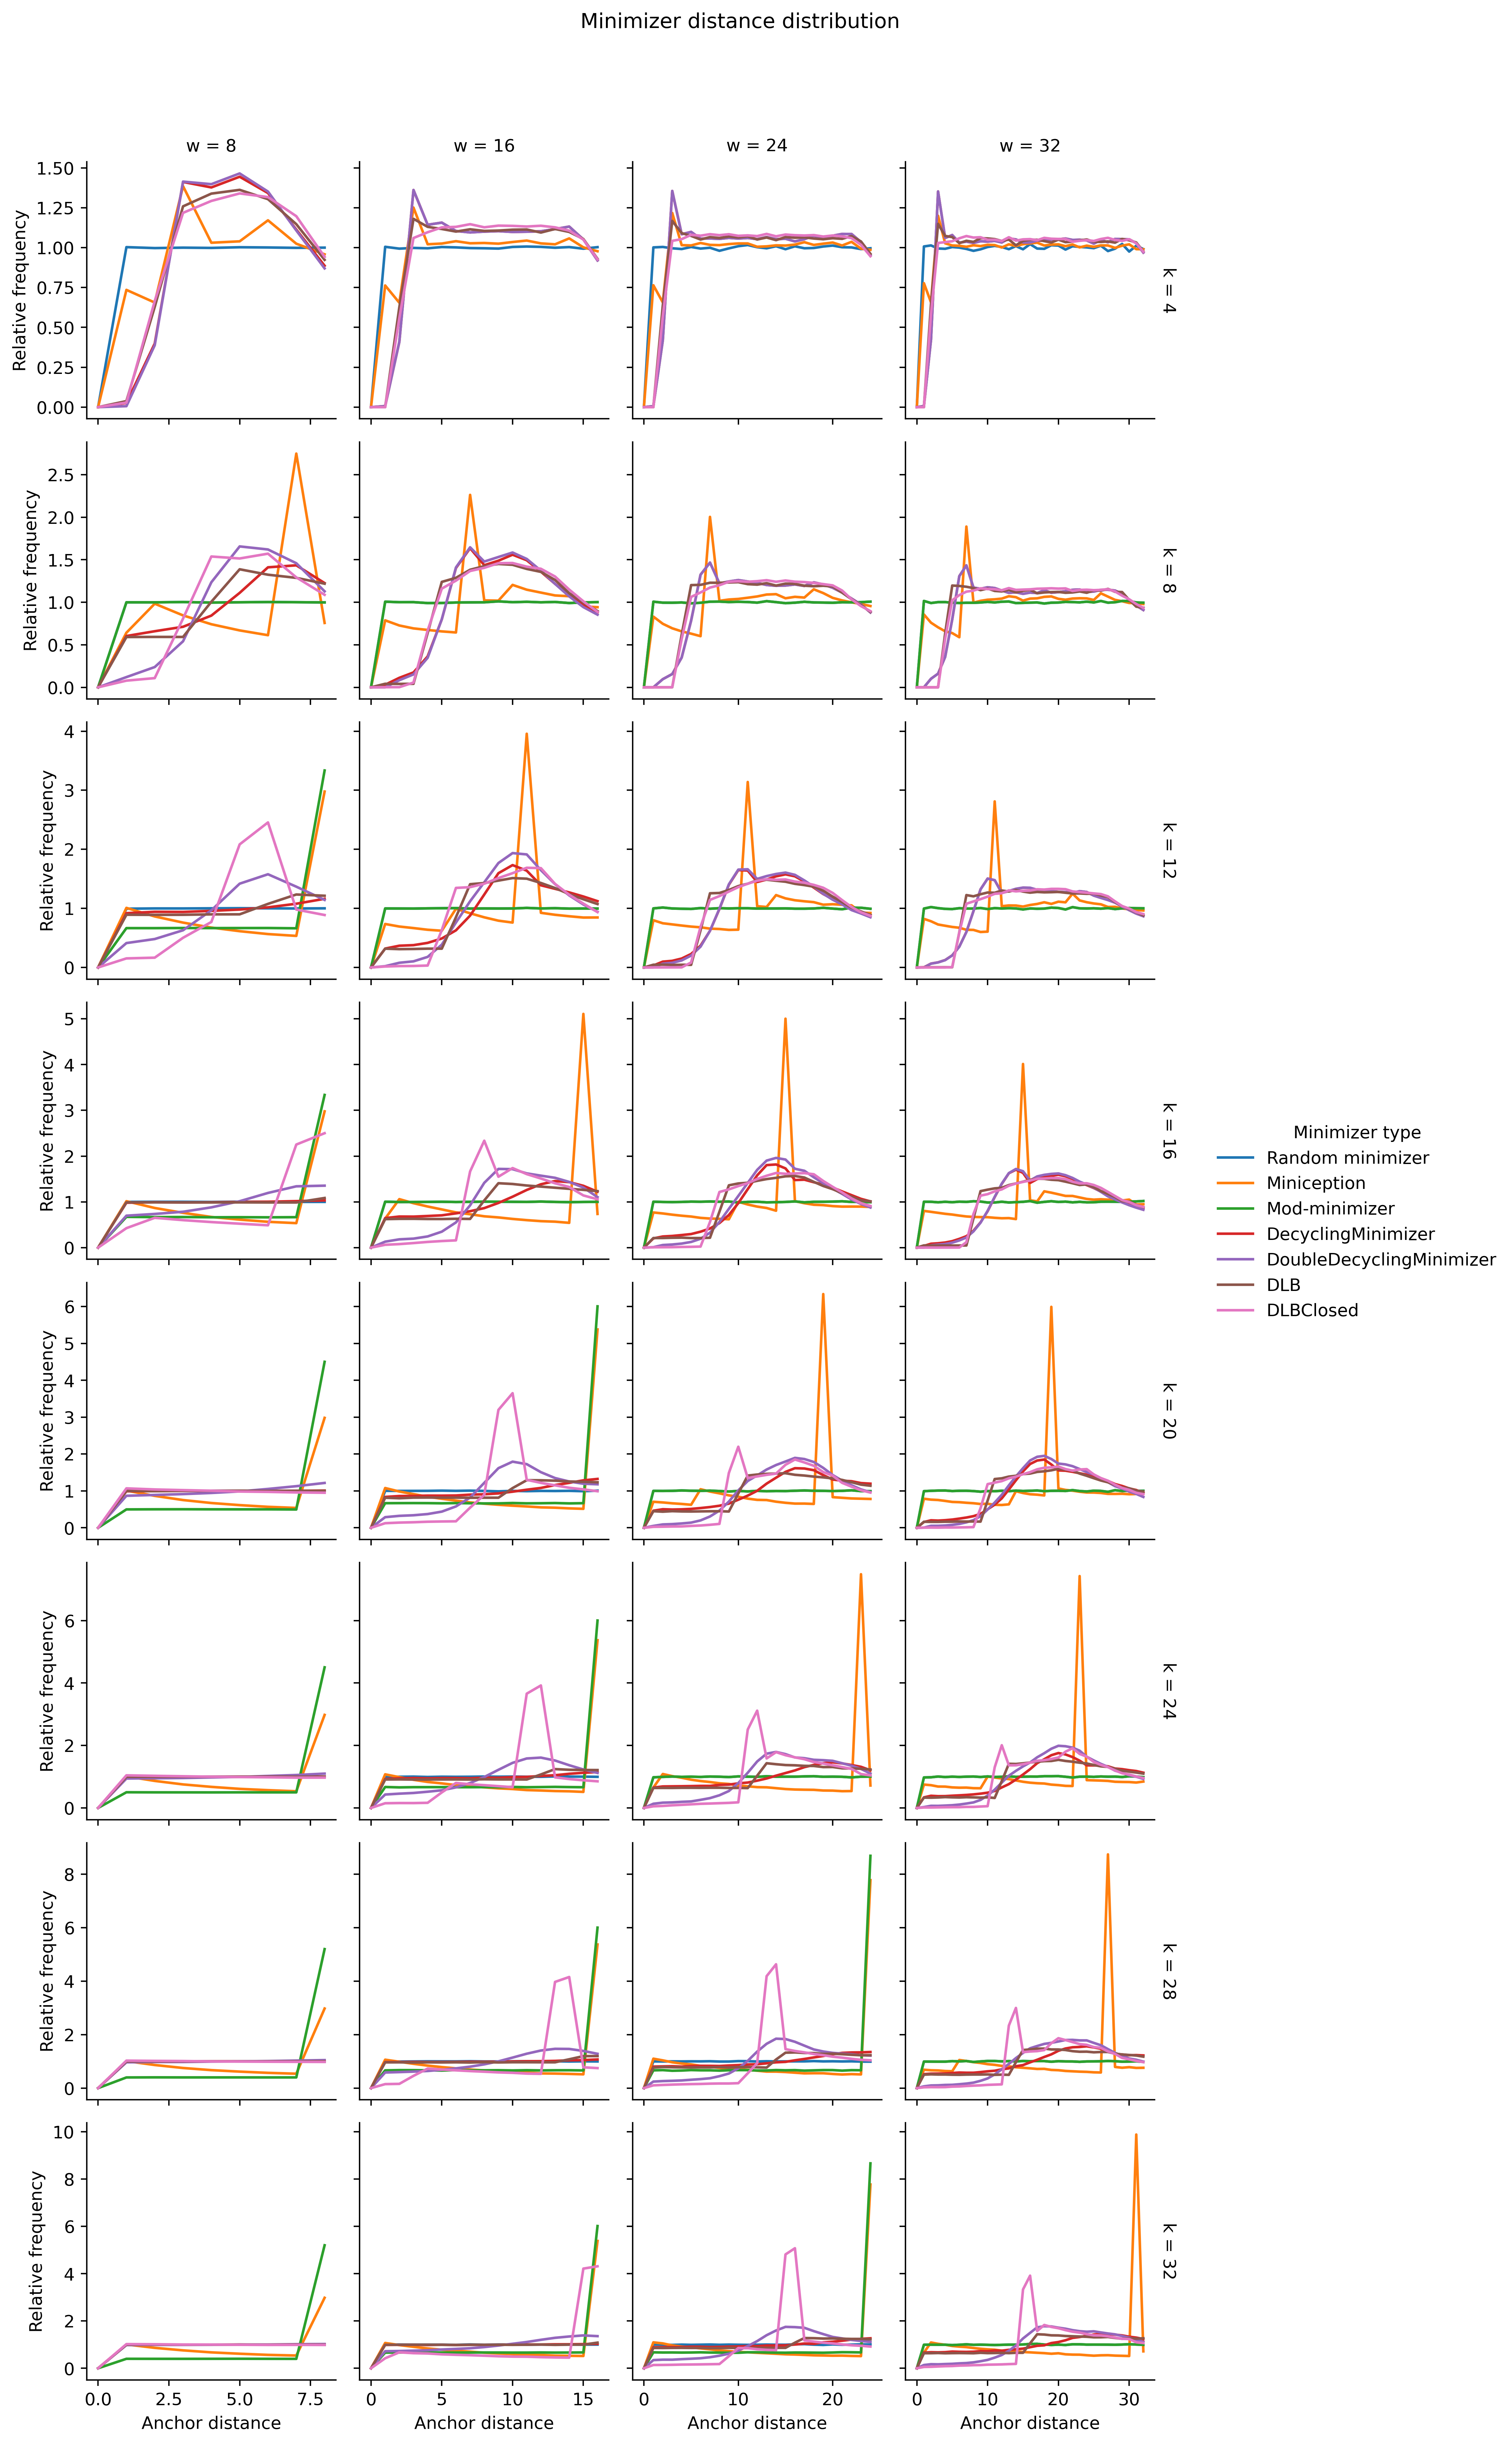

In [10]:
def plot(file):
    df = read(file)
    s = df['sigma'].unique()[0]

    # Plot position distribution.
    if True:
        # Flatten the data json object and add a new dist column.
        ddf = df.explode('positions').reset_index().rename(columns={'index' : 'position'})
        ddf['position'] = ddf.groupby('position').cumcount()
        g = sns.relplot(ddf,
                        kind='line',
                        x='position',
                        y='positions',
                        hue='Minimizer type',
                        row="k",
                        col="w",
                        facet_kws={
                            'sharex': "col",
                            'sharey': True,
                            'margin_titles': True,
                            'ylim': (0.7, 1.3),
                        },
                        height=2.5,

                        )
        g.fig.subplots_adjust(top=0.92) # adjust the Figure in rp
        g.fig.suptitle('Minimizer position distribution')
        g.set_axis_labels("Selected position", "Relative frequency")
        plt.savefig(f'../fig/positions_{s}.svg', bbox_inches='tight')
        plt.show()

    # Plot distance distribution.
    if True:
        # Flatten the data json object and add a new dist column.
        ddf = df.explode('dists').reset_index().rename(columns={'index' : 'dist'})
        ddf['dist'] = ddf.groupby('dist').cumcount()-ddf.w
        ddf = ddf[(ddf.dists > 0) | (ddf.dist >= 0)]
        # display(ddf[ddf.dist<0])
        g = sns.relplot(ddf,
                        kind='line',
                        x='dist',
                        y='dists',
                        hue='Minimizer type',
                        row="k",
                        col="w",
                        facet_kws={
                            'sharex': "col",
                            'sharey': "row",
                            'margin_titles': True,
                            # 'ylim': (0.7, 1.3),
                        },
                        height=2.5,
                        )
        g.fig.subplots_adjust(top=0.92) # adjust the Figure in rp
        g.fig.suptitle('Minimizer distance distribution')
        g.set_axis_labels("Anchor distance", "Relative frequency")
        plt.savefig(f'../fig/dists_{s}.svg', bbox_inches='tight')
        plt.show()

    # Plot parameter choice.
    if False:
        # Show pivot table of optimal parameter for rows k and cols w
        pdf = df[df["Minimizer type"]=="Modified miniception"].pivot_table(index='k', columns='w', values='param')
        display(pdf)

plot('stats_256.json')